In [124]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy import stats

from z24_dataset import z24Dataset
from shallow_model import Model

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [30]:
class z24Dataset(Dataset):
    def __init__(self, damage_case='1', filename = '40C07',window_size=100, normalize=True):
        self.window_size = window_size
        self.slices_per_file = 65536 // self.window_size
        self.normalize = normalize
        self.damage_case = damage_case
        self.filename = filename
            
        self.env_mean = np.load('../tools/env_mean.npy')
        self.env_std = np.load('../tools/env_std.npy')
        self.vibration_mean = np.load('../tools/vibration_mean.npy')
        self.vibration_std = np.load('../tools/vibration_std.npy')

    def __len__(self):
        return self.slices_per_file

    def __getitem__(self, index):
        index_to_read = index // self.slices_per_file
        index_in_dataframe = (index - index_to_read*self.slices_per_file) * self.window_size
        
        file_path_vib = '../data/z24_damage/'+self.damage_case+'/'+self.filename+'_vibrations.npy'
        file_path_env = '../data/z24_damage/'+self.damage_case+'/'+self.filename+'_env.npy'

        memmap_vib = np.memmap(file_path_vib, dtype=np.float64, mode='r', shape=(65536, 7))
        memmap_env = np.memmap(file_path_env, dtype=np.float64, mode='r', shape=(53,))

        X_environmental = np.array(memmap_env[:])
        X_vibration_window = np.array(memmap_vib[index_in_dataframe:index_in_dataframe+self.window_size,:])

        if self.normalize:
            X_vibration_window = (X_vibration_window - self.vibration_mean) / self.vibration_std
            X_environmental = (X_environmental - self.env_mean) / self.env_std
        
        X_vib_and_env = np.append(X_vibration_window.flatten(),X_environmental)
       
        return X_vib_and_env, X_vibration_window.flatten()
    

In [102]:

dataset = z24Dataset(damage_case='7', filename = '42E18',window_size=100, normalize=True)
#dataset = z24Dataset(damage_case='1', filename = '40C07',window_size=100, normalize=True)

dataloader = DataLoader(dataset, batch_size=100, shuffle=False, num_workers=4)


In [103]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 100


model = torch.load(f='../results/trained_autoencoder_memmap.pt', map_location='cpu')
loss_criterion = torch.nn.MSELoss(reduce=False)

In [116]:
all_window_loss = []
for X, Y in dataloader:
    X_tensor = X.float().to(device)
    Y_tensor = Y.float().to(device)

    batch_size, output_size = Y.shape
    N = 100
    N_predictions = torch.zeros([N, batch_size, output_size])

    for i in range(N):
        N_predictions[i,:,:] = model(X_tensor)

    prediction_mean = torch.mean(N_predictions, dim=0)
    prediction_std = torch.std(N_predictions, dim=0)

    loss_full = loss_criterion(prediction_mean, Y_tensor)

    lower_y = prediction_mean - 2*prediction_std
    upper_y = prediction_mean + 2*prediction_std
    within_lower = Y_tensor > lower_y
    within_upper = Y_tensor < upper_y
    within_range = within_lower & within_upper

    loss_full[within_range] = 0

    for j in range(batch_size):
        #loss_full[j,:100] = 0  ###############################################################taka ut sensor 1
        window_loss = torch.sum(loss_full[j,:]) / torch.numel(loss_full[j,:])
        all_window_loss.append(window_loss.item())
        
losses_no_outliers = np.sort(all_window_loss)[:int(0.95*len(all_window_loss))]

In [166]:
testset_errors = np.load('../results/testset_error_distribution.npy')
stats.ks_2samp(np.random.choice(testset_errors,655), np.random.choice(testset_errors,655))

Ks_2sampResult(statistic=0.05496183206106875, pvalue=0.26831877281292715)

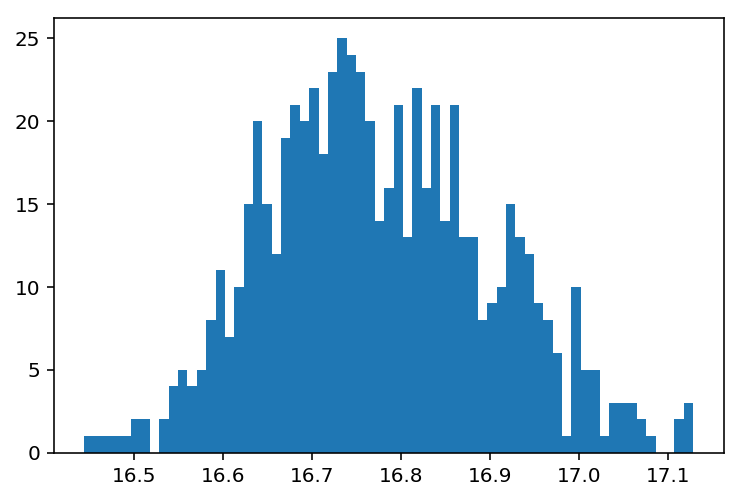

In [122]:
plt.hist(all_window_loss, bins=65)
plt.show()

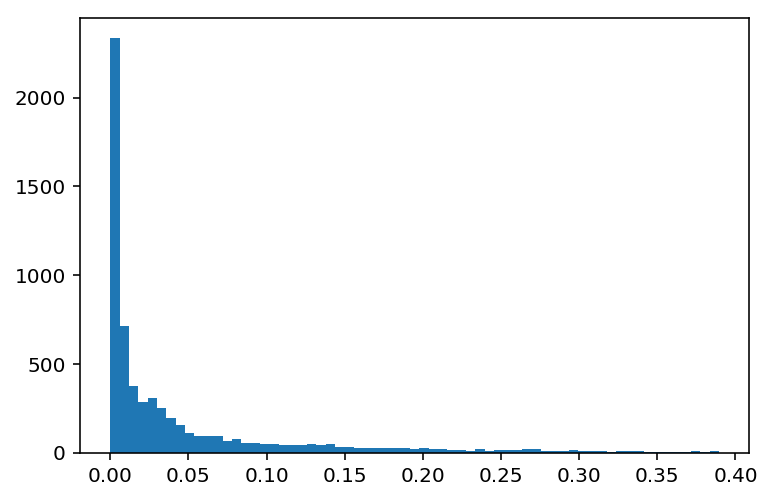

In [126]:
plt.hist(testset_errors, bins=65)
plt.show()

In [113]:
b = 2

lol=prediction_mean[b,:].detach().numpy()
lol = np.reshape(lol, [100,7])

lol_std = prediction_std[b,:].detach().numpy()
lol_std = np.reshape(lol_std, [100,7])

lol_true = Y_tensor[b,:].detach().numpy()
lol_true = np.reshape(lol_true, [100,7])


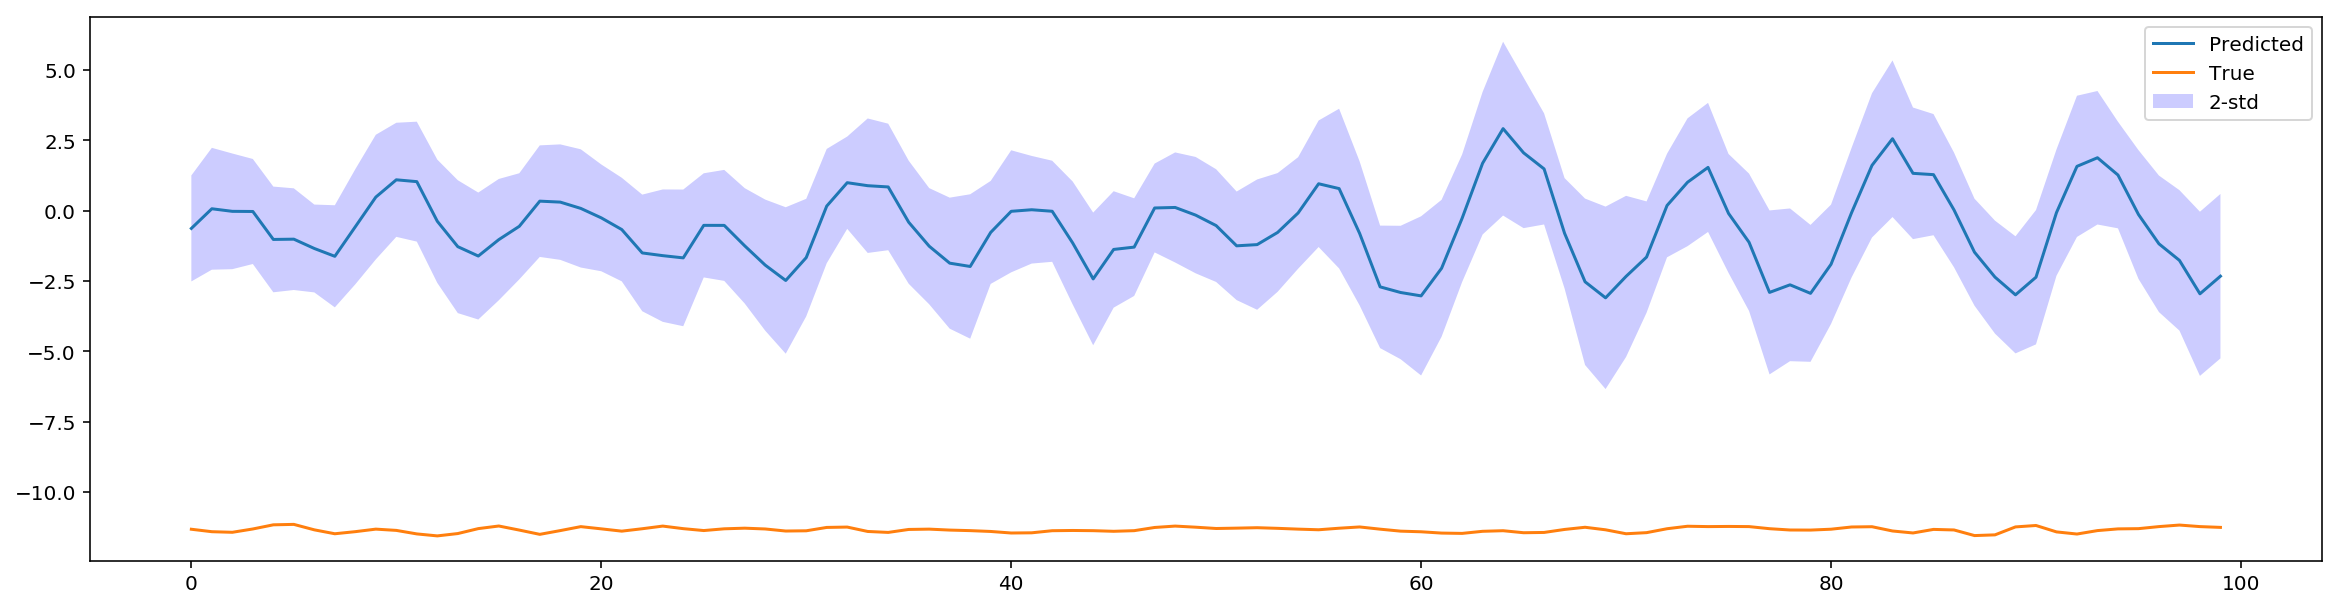

In [114]:
i = 0
plt.figure(figsize=(20,5))
#plt.ylim([-1,1])
plt.plot(lol[:,i], label='Predicted')
plt.fill_between(range(100), lol[:,i]-2*lol_std[:,i], lol[:,i]+2*lol_std[:,i], 
                 facecolor='blue', interpolate=True, alpha=0.2, label='2-std')
plt.plot(lol_true[:,i], label='True')
plt.legend()

In [167]:
class z24Dataset(Dataset):
    def __init__(self, filename = '04G03',window_size=100, normalize=True):
        self.window_size = window_size
        self.slices_per_file = 65536 // self.window_size
        self.normalize = normalize
        self.filename = filename
            
        self.env_mean = np.load('../tools/env_mean.npy')
        self.env_std = np.load('../tools/env_std.npy')
        self.vibration_mean = np.load('../tools/vibration_mean.npy')
        self.vibration_std = np.load('../tools/vibration_std.npy')

    def __len__(self):
        return self.slices_per_file

    def __getitem__(self, index):
        index_to_read = index // self.slices_per_file
        index_in_dataframe = (index - index_to_read*self.slices_per_file) * self.window_size
        
        file_path_vib = '../data/z24_clean/'+self.filename+'_vibrations.npy'
        file_path_env = '../data/z24_clean/'+self.filename+'_env.npy'

        memmap_vib = np.memmap(file_path_vib, dtype=np.float64, mode='r', shape=(65536, 7))
        memmap_env = np.memmap(file_path_env, dtype=np.float64, mode='r', shape=(53,))

        X_environmental = np.array(memmap_env[:])
        X_vibration_window = np.array(memmap_vib[index_in_dataframe:index_in_dataframe+self.window_size,:])

        if self.normalize:
            X_vibration_window = (X_vibration_window - self.vibration_mean) / self.vibration_std
            X_environmental = (X_environmental - self.env_mean) / self.env_std
        
        X_vib_and_env = np.append(X_vibration_window.flatten(),X_environmental)
       
        return X_vib_and_env, X_vibration_window.flatten()
    

In [168]:
dataset = z24Dataset(filename = '04G03',window_size=100, normalize=True)

dataloader = DataLoader(dataset, batch_size=100, shuffle=False, num_workers=4)


In [169]:
all_window_loss = []
for X, Y in dataloader:
    X_tensor = X.float().to(device)
    Y_tensor = Y.float().to(device)

    batch_size, output_size = Y.shape
    N = 100
    N_predictions = torch.zeros([N, batch_size, output_size])

    for i in range(N):
        N_predictions[i,:,:] = model(X_tensor)

    prediction_mean = torch.mean(N_predictions, dim=0)
    prediction_std = torch.std(N_predictions, dim=0)

    loss_full = loss_criterion(prediction_mean, Y_tensor)

    lower_y = prediction_mean - 2*prediction_std
    upper_y = prediction_mean + 2*prediction_std
    within_lower = Y_tensor > lower_y
    within_upper = Y_tensor < upper_y
    within_range = within_lower & within_upper

    loss_full[within_range] = 0

    for j in range(batch_size):
        #loss_full[j,:100] = 0  ###############################################################taka ut sensor 1
        window_loss = torch.sum(loss_full[j,:]) / torch.numel(loss_full[j,:])
        all_window_loss.append(window_loss.item())
        
losses_no_outliers = np.sort(all_window_loss)[:int(0.95*len(all_window_loss))]

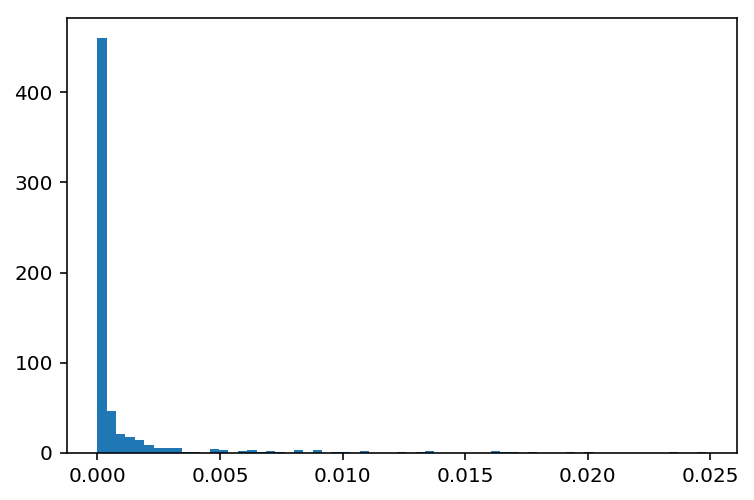

In [172]:
plt.hist(losses_no_outliers, bins=65)
plt.show()

In [234]:
s = np.random.choice(testset_errors,655)
stats.ks_2samp(np.random.choice(testset_errors,10), np.random.choice(losses_no_outliers, 10))

Ks_2sampResult(statistic=1.0, pvalue=1.8879793657162556e-05)

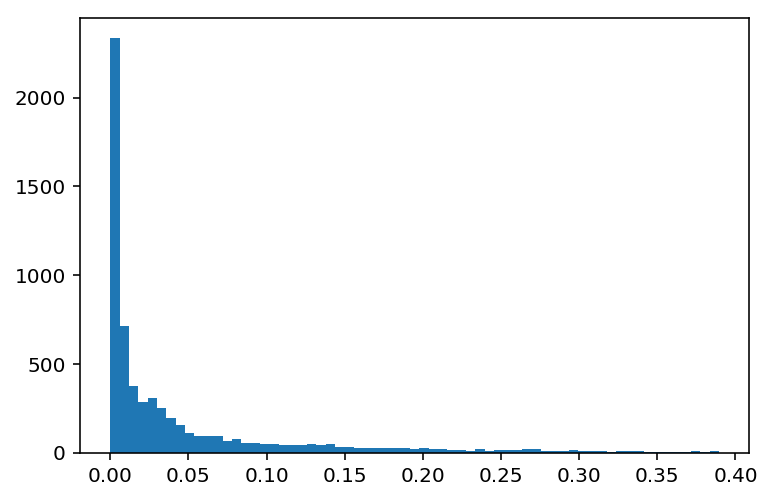

In [186]:
plt.hist(testset_errors, bins=65)
plt.show()

Ks_2sampResult(statistic=0.8748091603053435, pvalue=6.245011941840854e-05)

In [ ]:
#95 prosent innan marka